#### Name : Pradeep Kumar Chennuru

In [ ]:
#Importing key libraries, and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
data = pd.read_csv(r"MSFT-1.csv")

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [ ]:
# I picked the "Low" column to work on

Low_data = data.iloc[:,3:4].values

In [ ]:
Low_data           # checking the data

array([[ 59.779999],
       [ 60.150002],
       [ 59.200001],
       ...,
       [330.649994],
       [329.51001 ],
       [334.420013]])

In [ ]:
data.shape

(1259, 7)

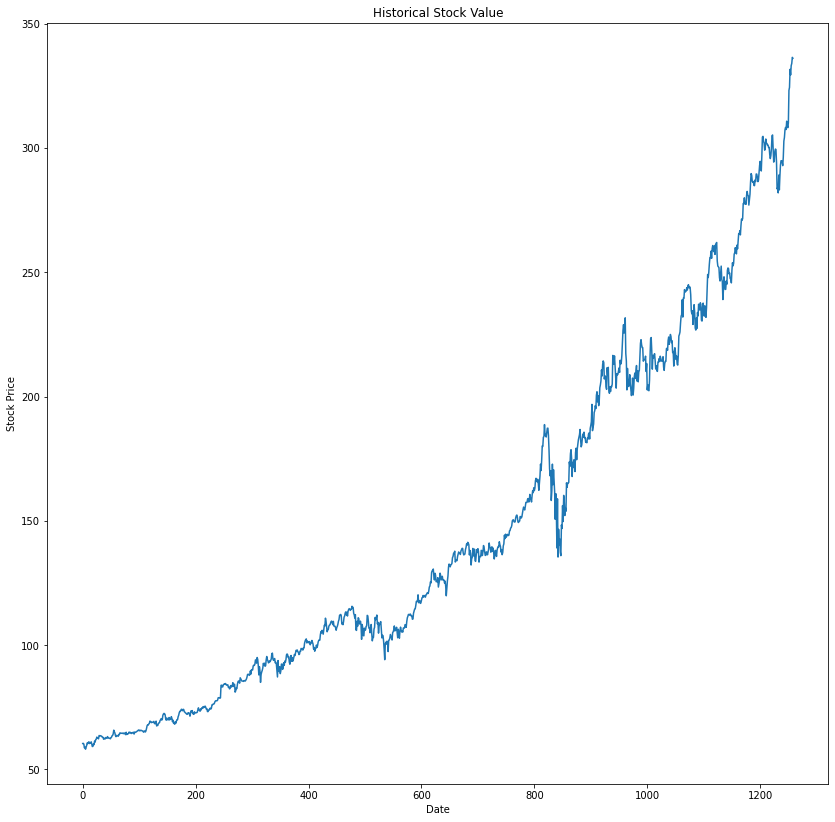

In [ ]:
#plotting graph for close price
df1 = data.reset_index()['Close']
plt.figure(figsize=(14,14))
plt.plot(df1)
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

we are going to use only one column "close" for time series analysis.



In [ ]:
df_close = data['Close'].values
df_close = df_close.reshape(-1,1)

In [ ]:
df_close.shape

(1259, 1)

In [ ]:
train = len(df_close)*0.8
train = int(train)
train, test = df_close[0:train, :], df_close[train:len(df_close), :1]

In [ ]:
train.shape


(1007, 1)

In [ ]:
test.shape


(252, 1)

Data PreProcess

In [ ]:
# Importing the training set
dataset_train = pd.read_csv(r"MSFT-1.csv")
# '.values' need the 2nd Column Opening Price as a Numpy array (not vector)
# '1:2' is used because the upper bound is ignored
training_set = dataset_train.iloc[:, 1:2].values

In [ ]:
# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Show the dataset we're working with
display(dataset_train)

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800
...,...,...,...,...,...,...,...
1254,11/1/2021,331.359985,331.489990,326.369995,329.369995,329.369995,27073200
1255,11/2/2021,330.309998,333.450012,330.000000,333.130005,333.130005,26487100
1256,11/3/2021,333.899994,334.899994,330.649994,334.000000,334.000000,21500100
1257,11/4/2021,332.890015,336.540009,329.510010,336.440002,336.440002,23992200


In [ ]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

In [ ]:
# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [ ]:
# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 17s 175ms/step - loss: 0.0263
Epoch 2/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0026
Epoch 3/100
38/38 [==============================] - 5s 137ms/step - loss: 0.0027
Epoch 4/100
38/38 [==============================] - 6s 166ms/step - loss: 0.0026
Epoch 5/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0024
Epoch 6/100
38/38 [==============================] - 6s 168ms/step - loss: 0.0022
Epoch 7/100
38/38 [==============================] - 5s 135ms/step - loss: 0.0026
Epoch 8/100
38/38 [==============================] - 7s 196ms/step - loss: 0.0023
Epoch 9/100
38/38 [==============================] - 5s 137ms/step - loss: 0.0020
Epoch 10/100
38/38 [==============================] - 5s 136ms/step - loss: 0.0019
Epoch 11/100
38/38 [==============================] - 6s 167ms/step - loss: 0.0019
Epoch 12/100
38/38 [==============================] - 6s 151ms/step - loss: 0.0020
Epoch 13/100

In [ ]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv(r"MSFT-1.csv")
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
# Getting the predicted stock price of 2017
# We need 60 previous inputs for each day of the Test_set in 2017
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [ ]:
# 'reshape' function to get it into a NumPy format
inputs = inputs.reshape(-1,1)

In [ ]:
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs = sc.transform(inputs)

In [ ]:
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

In [ ]:
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

In [ ]:
X_test = np.array(X_test)

In [ ]:
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 3s 3s/step


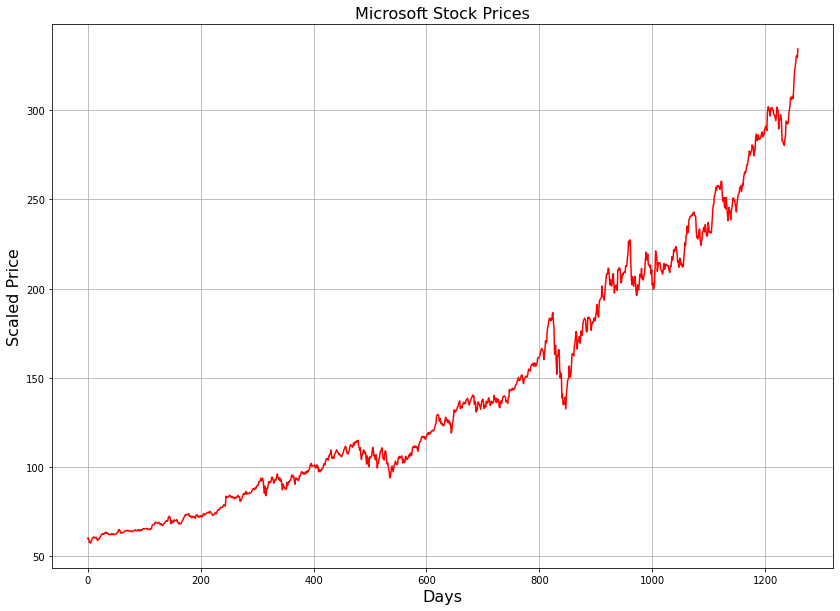

In [ ]:
# Visualizing the data
plt.figure(figsize=(14,10))
plt.plot(Low_data,c="red")
plt.title("Microsoft Stock Prices",fontsize=16)
plt.xlabel("Days",fontsize=16)
plt.ylabel("Scaled Price",fontsize=16)
plt.grid()
plt.show()



## Result
* Here the following of our simulations on the cross validation dataset, it appears that a 4-layered neural network, using 'Adam' as the optimizer along with a learning rate of 0.01, performs best. We proceed to introduce dropout in the model, and use the model to predict for the test set.

* Here the test predictions (submitted to Kaggle) generated by our model predicts with an accuracy score of 97.600%, which places us at the top 55 percentile of the competition.

Building RNN using LSTM Architecture


In [ ]:
#Normalizing data
scaling = MinMaxScaler(feature_range=(0,1))
train_ScaledData = scaling.fit_transform(train)
test_ScaledData = scaling.transform(test)

In [ ]:
# Function to create a 60 day window for train and test datasets
def data(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
X_train, Y_train = data(train_ScaledData, 60)

In [ ]:
X_test, Y_test = data(test_ScaledData, 60)

In [ ]:
#Reshaping for RNN
x_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
x_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
x_train.shape

(946, 60, 1)

In [ ]:
x_test.shape

(191, 60, 1)

In [ ]:
Y_train.shape

(946,)

Building RNN using LSTM Architecture


In [ ]:
model = Sequential([
    keras.layers.LSTM(256, return_sequences=True, input_shape=[x_train.shape[1], 1],
                     dropout=0.2),
    keras.layers.LSTM(256, return_sequences=True,
                     dropout=0.2),
    keras.layers.LSTM(256, return_sequences=True,
                     dropout=0.2),
    keras.layers.LSTM(256),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(x_train, Y_train, epochs=80,
                    validation_split=0.1, batch_size = 32)
model.save('rnn.h4')

Epoch 1/80
27/27 [==============================] - 40s 1s/step - loss: 0.0652 - val_loss: 0.0023
Epoch 2/80
27/27 [==============================] - 32s 1s/step - loss: 0.0039 - val_loss: 0.0025
Epoch 3/80
27/27 [==============================] - 32s 1s/step - loss: 0.0022 - val_loss: 0.0041
Epoch 4/80
27/27 [==============================] - 30s 1s/step - loss: 0.0029 - val_loss: 0.0043
Epoch 5/80
27/27 [==============================] - 37s 1s/step - loss: 0.0023 - val_loss: 0.0124
Epoch 6/80
27/27 [==============================] - 38s 1s/step - loss: 0.0023 - val_loss: 0.0063
Epoch 7/80
27/27 [==============================] - 41s 1s/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/80
27/27 [==============================] - 36s 1s/step - loss: 0.0025 - val_loss: 0.0073
Epoch 9/80
27/27 [==============================] - 37s 1s/step - loss: 0.0024 - val_loss: 0.0093
Epoch 10/80
27/27 [==============================] - 42s 2s/step - loss: 0.0021 - val_loss: 0.0024
Epoch 11/80
27/27 [

In [ ]:
y_pred = model.predict(x_test)
y_pred = scaling.inverse_transform(y_pred)

6/6 [==============================] - 3s 203ms/step


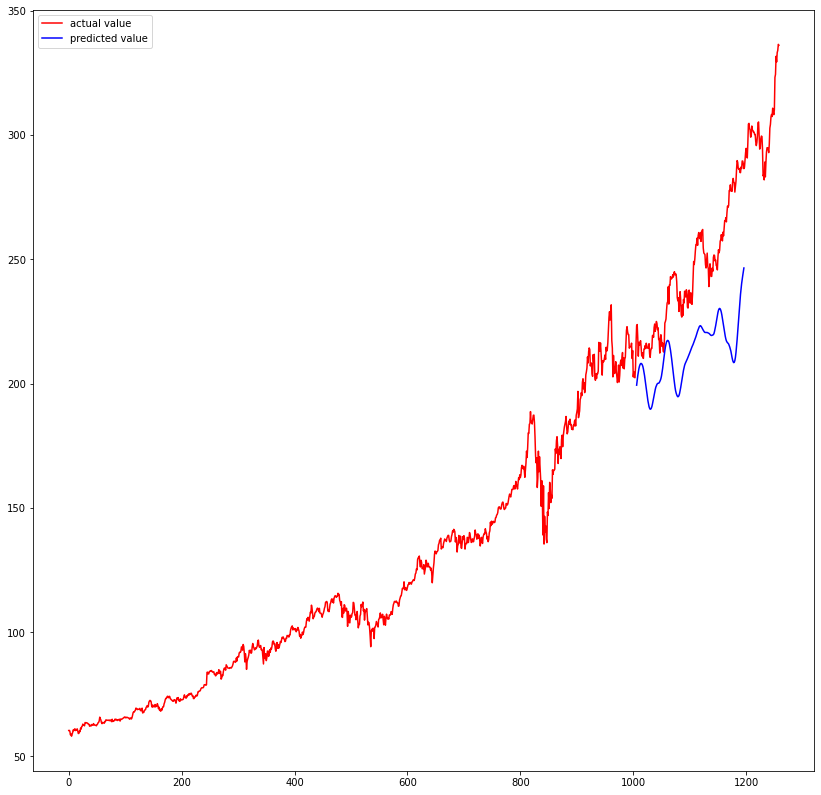

In [ ]:
# Visualizing the data
fig, ax = plt.subplots(figsize=(14, 14))
plt.plot(df_close, color='red', label='actual value')
ax.plot(range(len(Y_train)+60, len(Y_train)+60+len(y_pred)), y_pred, color='blue', label='predicted value')
plt.legend()

In [ ]:
import math
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [ ]:
train_predict=model.predict(x_train)

mse = math.sqrt(mean_squared_error(Y_test, y_pred))
print("The mean squares error is ", mse)

30/30 [==============================] - 7s 229ms/step
The mean squares error is  211.46749464803904


In [ ]:
train_predict=scaling.inverse_transform(train_predict)
math.sqrt(mean_squared_error(Y_train,train_predict))

119.14654794155379

Predicting MSFT stock prices from 11/08/2021 to 11/19/2021


In [ ]:
x = x_test[-1]
step = 10
predicts = []
for i in range(step):
    data = np.expand_dims(x, axis=0)
    pred = model.predict(data)
    pred = scaling.inverse_transform(pred)
    predicts.append(pred[0][0])
    x = np.delete(x, 0, axis=0)
    x = np.vstack([x, pred])
print(predicts)

1/1 [==============================] - 0s 44ms/step
[246.47682, 482.1061, 566.612, 605.93384, 627.671, 640.6142, 648.9267, 654.47064, 658.2395, 660.83026]


Linear model for other columns


In [ ]:
df = pd.read_csv(r"MSFT-1.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

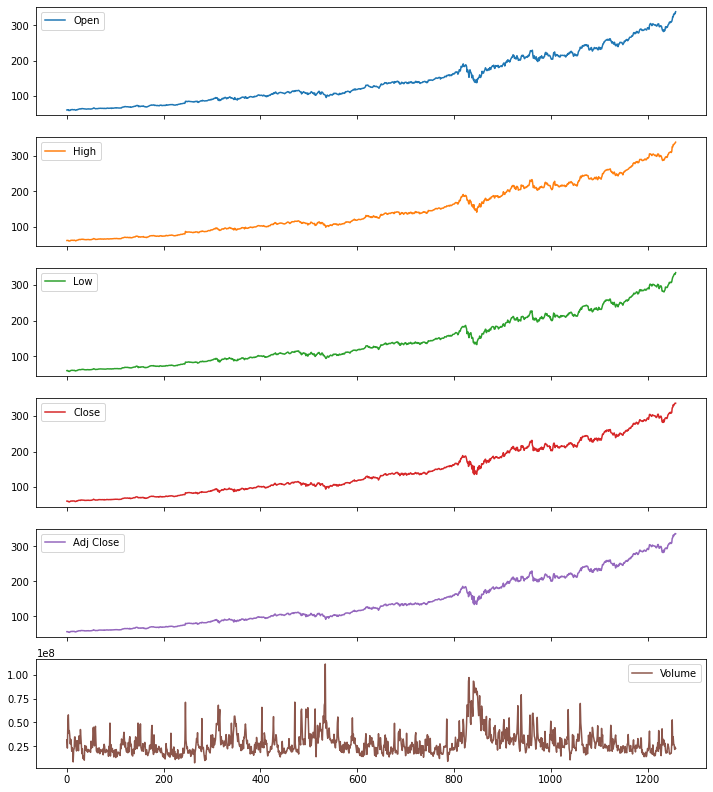

In [ ]:
df.plot(figsize=(12, 14), subplots=True)

In [ ]:
X_Open = df['Close'].values
X_Open = X_Open.reshape(-1,1)
Y_Open = df['Open'].values
Y_Open = Y_Open.reshape(-1,1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_Open, Y_Open, test_size = 0.3, random_state = 42)

In [ ]:
x_train.shape

(881, 1)

In [ ]:
x_test.shape

(378, 1)

In [ ]:
y_train.shape

(881, 1)

In [ ]:
y_test.shape

(378, 1)

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
open_pred = lr.predict(x_test)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, open_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, open_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, open_pred)))
print('R-squared Error:', metrics.r2_score(y_test, open_pred))

Mean Absolute Error: 1.3468938249252198
Mean Squared Error: 3.858623183112474
Root Mean Squared Error: 1.9643378485160017
R-squared Error: 0.9992319813488215
